In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/sparse-rf-project/sparse-rf/

/content/drive/MyDrive/sparse-rf-project/sparse-rf


In [3]:
pip install spgl1

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from sparse_rf.algs.core import min_wl2, min_l2, min_l1
from sparse_rf.modules import make_X, make_W, make_A
from sparse_rf.util import *
from sparse_rf.util.fns import *
from functools import partial
import numpy.linalg as la
import random
import gc

In [5]:
m = 1000
d = 5
N = 10000
active = fourier

ratio_train = 0.7

In [6]:
qs = [1, 2, 3, 4, 5]

In [7]:
def prune(w, A_train, A_test, y_train, y_test, method, per=20):
    thre = np.percentile(np.abs(w), per)
    idx = np.abs(w) > thre
    # output mse after pruninig--bad results
    y_pred = A_test[:, idx] @ w[idx]
    mse_prune = 1/len(y_test) * la.norm(y_pred - y_test)**2
    # print(f"mse after prunining with threshold {thre}: {mse_prune}")

    # retraining--IMP--good resultS
    A_trains = A_train[:, idx]
    A_tests = A_test[:, idx]
    w_prune = method(A_trains, y_train)
    y_preds = A_tests @ w_prune
    mse_retrain = 1/len(y_test) * la.norm(y_preds - y_test)**2
    print(f"mse after training with {w_prune.shape}")

    return A_trains, A_tests, w_prune, mse_prune, mse_retrain

def prune_total(A_train_sparse, A_test_sparse, y_train, y_test, c_l2_sparse, method, step=30, per=20):
    A_trains, A_tests, w_prune = A_train_sparse, A_test_sparse, c_l2_sparse
    mse_prune = []
    mse_retrain = []
    w_length = []

    for i in range(step):
        A_trains, A_tests, w_prune, msep, mser = prune(w_prune, A_trains, A_tests, y_train, y_test, method, per)
        mse_prune.append(msep)
        mse_retrain.append(mser)
        w_length.append(w_prune.shape[0])

    return w_length, mse_prune, mse_retrain

# double descent curve plot with randomly sampled weights
def reinit(X_train, X_test, y_train, y_test, d, q, method):
    res_reinit = []
     # new initialization
    for wl in w_length:
        W_sparse = make_W(d, q, N=wl//2, dist=normal)
        A_train_sparse = make_A(X_train, W_sparse, active=active)
        A_test_sparse = make_A(X_test, W_sparse, active=active)
        # print(A_train_sparse.shape, wl)

        c = method(A_train_sparse, y_train)
        res = np.linalg.norm(A_test_sparse@c-y_test)**2 / len(y_test)
        res_reinit.append(res)
    return res_reinit 

In [ ]:
X = make_X(d, m, dist=uniform)
X_train = X[:int(m*ratio_train), :]
X_test = X[int(m*ratio_train):, :]

y = fn3(X.T)
y_train = y[:int(m*ratio_train)]
y_test = y[int(m*ratio_train):]

seeds = [13]

results_l1_3 = []
results_l2_3 = []
prune_result = []
w_result = []
for q in qs:
    res_l1 = []
    res_l2 = []
    res_prune = []
    w_len = []
    
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        W = make_W(d, q, N=N, dist=partial(normal, stdev=1))
        A_train = make_A(X_train, W, active=active)
        A_test = make_A(X_test, W, active=active)

        c_l1 = min_l1(A_train, y_train)
        c_l2 = min_l2(A_train, y_train)

        res_l1.append(np.linalg.norm(A_test@c_l1 - y_test) / np.linalg.norm(y_test))
        res_l2.append(np.linalg.norm(A_test@c_l2 - y_test) / np.linalg.norm(y_test))

        w_length, mse_prune, mse_retrain = prune_total(A_train, A_test, y_train, y_test, c_l2, method=min_l2, step=30, per=20)
        idx = np.argmin(mse_retrain)
        res_prune.append(mse_retrain[idx])
        w_len.append(w_length[idx])


        del W
        del A_train
        del A_test
        del c_l1
        del c_l2

        gc.collect()

    results_l1_3.append(res_l1)
    results_l2_3.append(res_l2)
    prune_result.append(res_prune)
    w_result.append(w_len)

In [ ]:
X = make_X(d, m, dist=uniform)
X_train = X[:int(m*ratio_train), :]
X_test = X[int(m*ratio_train):, :]

y = fn6(X.T)
y_train = y[:int(m*ratio_train)]
y_test = y[int(m*ratio_train):]

seeds = [18]

results_l1_6 = []
results_l2_6 = []
prune_result_6 = []
w_result_6 = []


for q in qs:
    res_l1 = []
    res_l2 = []
    res_prune = []
    w_len = []
    
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        W = make_W(d, q, N=N, dist=partial(normal, stdev=1))
        A_train = make_A(X_train, W, active=active)
        A_test = make_A(X_test, W, active=active)

        c_l1 = min_l1(A_train, y_train)
        c_l2 = min_l2(A_train, y_train)

        res_l1.append(np.linalg.norm(A_test@c_l1 - y_test) / np.linalg.norm(y_test))
        res_l2.append(np.linalg.norm(A_test@c_l2 - y_test) / np.linalg.norm(y_test))

        w_length, mse_prune, mse_retrain = prune_total(A_train, A_test, y_train, y_test, c_l2, method=min_l2, step=30, per=20)
        idx = np.argmin(mse_retrain)
        res_prune.append(mse_retrain[idx])
        w_len.append(w_length[idx])


        del W
        del A_train
        del A_test
        del c_l1
        del c_l2

        gc.collect()

    results_l1_6.append(res_l1)
    results_l2_6.append(res_l2)
    prune_result_6.append(res_prune)
    w_result_6.append(w_len)

In [36]:
res_re = []
for q in qs:
    print(q)
    res_reinit = reinit(X_train, X_test, y_train, y_test, d, q, method=min_l2)
    res_re.append(res_reinit)

1
2
3
4
5


fn3, l1: [0.13000903795890986, 0.05308400406032302, 0.05948300497884853, 0.058624346127769004, 0.06336065020564206]
fn3, l2: [0.13325570674128448, 0.0016457147849677748, 0.07946784463870973, 0.11985436911494085, 0.1136808872358191]
fn3, l2_prune: [0.015280954053554001, 4.5934273344743e-07, 3.700619466702709e-05, 0.0006185667536262647, 0.0009888961114069199]


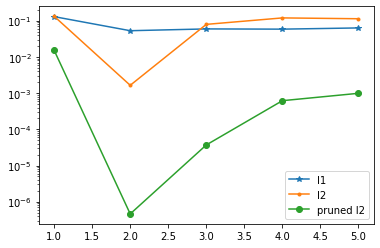

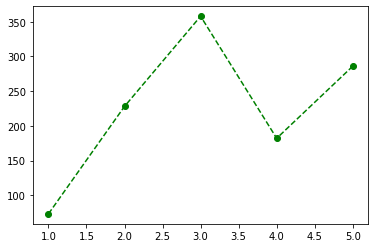

In [24]:
print("fn3, l1: {}".format([np.mean(res) for res in results_l1_3]))
print("fn3, l2: {}".format([np.mean(res) for res in results_l2_3]))
print("fn3, l2_prune: {}".format([np.mean(res) for res in prune_result]))
plt.semilogy(qs, [np.mean(res) for res in results_l1_3], '*-', label="l1")
plt.semilogy(qs, [np.mean(res) for res in results_l2_3], '.-', label="l2")
plt.semilogy(qs, [np.mean(res) for res in prune_result], 'o-', label="pruned l2")
plt.legend()
plt.show()

plt.plot(qs, w_result, 'go--', label="l2")

fn6, l1: [1.0112951549752764, 0.20632067413168756, 0.08836135280719783, 0.073800595577955, 0.06703152911874143]
fn6, l2: [1.0648518105129454, 0.826671101948829, 0.024041397847634496, 0.02921286488152489, 0.04461661011947821]
fn6, l2_prune: [0.08894490673520783, 0.011177212642173423, 8.556512457946358e-08, 7.235785548023244e-06, 1.0694051929794084e-05]


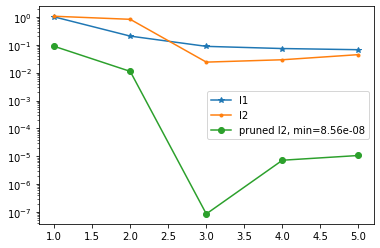

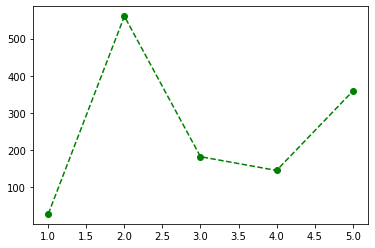

In [35]:
print("fn6, l1: {}".format([np.mean(res) for res in results_l1_6]))
print("fn6, l2: {}".format([np.mean(res) for res in results_l2_6]))

print("fn6, l2_prune: {}".format([np.mean(res) for res in prune_result_6]))
plt.semilogy(qs, [np.mean(res) for res in results_l1_6], '*-', label="l1")
plt.semilogy(qs, [np.mean(res) for res in results_l2_6], '.-', label="l2")
plt.semilogy(qs, [np.mean(res) for res in prune_result_6], 'o-', label="pruned l2, min={:.2e}".format(min(prune_result_6)[0]))
plt.legend()
plt.show()

plt.plot(qs, w_result_6, 'go--', label="l2")

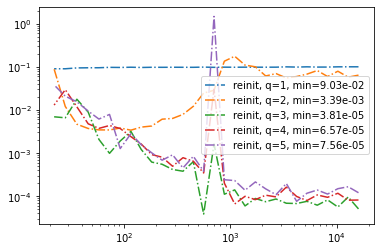

In [38]:
for i,q in enumerate(qs):
    plt.loglog(w_length, res_re[i], '-.', label="reinit, q={}, min={:.2e}".format(q, min(res_re[i])))
plt.legend()